In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import shap

In [3]:
raw_data_joined = pd.read_csv('./output/raw_data_joined.csv', index_col=0)

In [17]:
comorb_lst = [i for i in raw_data_joined.columns if "DISEASE" in i]
comorb_lst.extend(["HTN", "IMMUNOCOMPROMISED", "OTHER"])

demo_lst = [i for i in raw_data_joined.columns if "AGE_" in i]
demo_lst.append("GENDER")


vitalSigns_lst = raw_data_joined.iloc[:,193:-2].columns.tolist()

lab_lst = raw_data_joined.iloc[:,13:193].columns.tolist()

As warned by the authors ("Beware NOT to use the data when the target variable is present, as it is unknown the order of the event (maybe the target event happened before the results were obtained)") which means that the inpatient's lab results could have been obtained after the inpatient's entry in the ICU thus rendering that data pointless

We will focus on creating a model that works within the 0-2 window since it's more clinically relevant. Therefore, all the data from patients admitted between the 0-2 window should be dropped

In [5]:
# ICU per window
pd.crosstab(raw_data_joined.WINDOW, raw_data_joined.ICU)

ICU,0,1
WINDOW,,
0-2,353,32
2-4,326,59
4-6,286,99
6-12,255,130
ABOVE_12,190,195


In [10]:
# Dropping the patients which were admitted to ICU in the first window
train_data = raw_data_joined.loc[~((raw_data_joined['WINDOW'] == '0-2') & (raw_data_joined['ICU'] == 1))]
train_data

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
3,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0
4,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,384,0,50,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1921,384,0,50,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
1922,384,0,50,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
1923,384,0,50,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0


train_data is our dataset fully cleaned and ready to be split up in different ways to be fit into different models

In [11]:
icu_above_2 = train_data.groupby('PATIENT_VISIT_IDENTIFIER')\
    .agg({'ICU': max})\
    .reset_index()\
    .rename(columns={'ICU': 'ICU_NEW'})
    
# Merge back to original df
training_data = train_data.merge(icu_above_2, on=['PATIENT_VISIT_IDENTIFIER'], how='left')

It is important to notice the addition of a new column at the end of the dataset that tells us if the patient went into the ICU after the window we are studying to obtain the groundtruth value

In [12]:
training_data.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_NEW
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,1
1,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0,1
2,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0,1
3,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0,1
4,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1,1


In [13]:
# Valid cases per window
pd.crosstab(training_data.WINDOW, training_data.ICU)

ICU,0,1
WINDOW,,
0-2,353,0
2-4,326,59
4-6,286,99
6-12,255,130
ABOVE_12,190,195


In [14]:
# keep only features from 0-2 hour window
mask_02 = training_data.WINDOW == '0-2'
training_data = training_data.loc[mask_02]

# valid cases for training
pd.crosstab(training_data.WINDOW, training_data.ICU_NEW)

ICU_NEW,0,1
WINDOW,,
0-2,190,163


We are left with 353 rows total but is as expected taking into account the demand for clinically relevant results

In [15]:
training_data

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_NEW
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,1
9,2,0,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,0,1
14,3,0,40,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0
19,4,0,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0,0
24,5,0,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,380,0,40,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,1
1873,381,1,90,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.612627,-1.000000,0-2,0,0
1878,382,0,50,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,1
1883,383,0,40,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0


In [18]:
features = ['AGE_PERCENTIL', 'GENDER'] + comorb_lst + lab_lst + vitalSigns_lst
X = training_data[features]
y = training_data['ICU_NEW']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                  random_state=0)

In [25]:
models = {
    "k-nearesr": KNeighborsClassifier(),
    "logis": LogisticRegression(C=10,solver="lbfgs"),
    #"svm-linear": CalibratedClassifierCV(LinearSVC(),cv=3),
    "svm-rbf": CalibratedClassifierCV(SVC(kernel="sigmoid",gamma="auto"),cv=3),
    "randomforest": RandomForestClassifier(n_estimators=100),
}

In [26]:
for name,m  in models.items():
    print(f"Training {name}...")
    m.fit(X_train, y_train)
print("Train complete")

Training k-nearesr...
Training logis...
Training svm-rbf...
Training randomforest...


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train complete


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.iforest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The

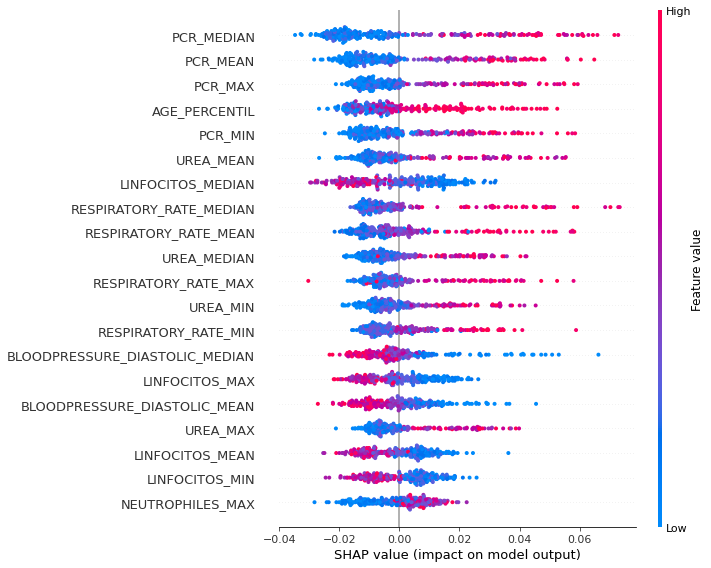

In [27]:
explainer   = shap.TreeExplainer(m)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], X_train)

In [29]:
printMetric = lambda label,value:print(f"\t {label}: {round(value,3)}")

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"Evaluating model {name}")
    printMetric("Accuracy",accuracy_score(y_test, y_pred))
    printMetric("Precision",precision_score(y_test, y_pred))
    printMetric("Recall",recall_score(y_test, y_pred))
    printMetric("F1Score",f1_score(y_test, y_pred))

print("Train complete")

Evaluating model k-nearesr
	 Accuracy: 0.648
	 Precision: 0.643
	 Recall: 0.545
	 F1Score: 0.59
Evaluating model logis
	 Accuracy: 0.732
	 Precision: 0.75
	 Recall: 0.636
	 F1Score: 0.689
Evaluating model svm-rbf
	 Accuracy: 0.662
	 Precision: 0.6
	 Recall: 0.818
	 F1Score: 0.692
Evaluating model randomforest
	 Accuracy: 0.746
	 Precision: 0.727
	 Recall: 0.727
	 F1Score: 0.727
Train complete


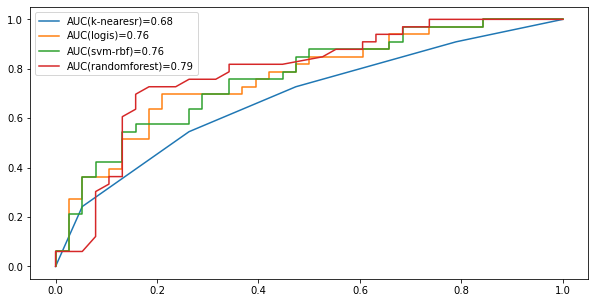

In [31]:
analyzeModels = {
    name:model for name, model in models.items()
}

plt.figure(figsize=(10,5))
aucs = []
for name, model in analyzeModels.items():
    y_scores = model.predict_proba(X_test)
    
    alive_scores = y_scores[:,1]
    
    # Extract AUC score
    auc = roc_auc_score(y_test, alive_scores)
    aucs.append(f"AUC({name})={round(auc,2)}")
    # Extract ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, alive_scores, pos_label=1)
    plt.plot(fpr,tpr)

plt.legend(aucs)

In [33]:
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=10)
    print(f"({name}) acccuracy={np.mean(scores)}")

(k-nearesr) acccuracy=0.6521428571428571


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scik

(logis) acccuracy=0.7280158730158729
(svm-rbf) acccuracy=0.6059523809523808
(randomforest) acccuracy=0.7111904761904762


In [35]:
# Precision, Recall, F1-Score & Support
#print(classification_report(y_test,y_pred))
# Accuracy Score -> in mutliclass is computed with jaccard_score
#print(accuracy_score(y_test, y_pred))

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"MODEL -> {name}")
    print(classification_report(y_test,y_pred))

MODEL -> k-nearesr
              precision    recall  f1-score   support

           0       0.65      0.74      0.69        38
           1       0.64      0.55      0.59        33

    accuracy                           0.65        71
   macro avg       0.65      0.64      0.64        71
weighted avg       0.65      0.65      0.64        71

MODEL -> logis
              precision    recall  f1-score   support

           0       0.72      0.82      0.77        38
           1       0.75      0.64      0.69        33

    accuracy                           0.73        71
   macro avg       0.74      0.73      0.73        71
weighted avg       0.73      0.73      0.73        71

MODEL -> svm-rbf
              precision    recall  f1-score   support

           0       0.77      0.53      0.62        38
           1       0.60      0.82      0.69        33

    accuracy                           0.66        71
   macro avg       0.68      0.67      0.66        71
weighted avg       0.69

In [36]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline

pipeline = [
    StandardScaler(),
    Normalizer()
]

tr = make_pipeline(*pipeline)

In [37]:
data_prueba = raw_data_joined.iloc[:,4:229]

In [38]:
X_ready = tr.fit_transform(data_prueba)
X_ready = pd.DataFrame(X_ready, columns=data_prueba.columns)

In [40]:
data_prueba_dem = raw_data_joined.iloc[:,0:4]

In [41]:
data_prueba_pycaret = data_prueba_dem.join(X_ready)

In [43]:
aux_df_pycaret = raw_data_joined.iloc[:,229:231]

In [44]:
data_prueba_pycaret = data_prueba_pycaret.join(aux_df_pycaret)

In [45]:
data_prueba_pycaret

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60,0,-0.041853,-0.020429,-0.039560,-0.017064,0.314148,0.542968,...,-0.070432,-0.039602,-0.066468,-0.067127,-0.066671,-0.061639,-0.070358,-0.039569,0-2,0
1,0,1,60,0,-0.037514,-0.018311,-0.035459,-0.015295,0.281580,0.486677,...,-0.063130,-0.035497,-0.059577,-0.060168,-0.059759,-0.055248,-0.063064,-0.035467,2-4,0
2,0,1,60,0,-0.037514,-0.018311,-0.035459,-0.015295,0.281580,0.486677,...,-0.063130,-0.035497,-0.059577,-0.060168,-0.059759,-0.055248,-0.063064,-0.035467,4-6,0
3,0,1,60,0,-0.041088,-0.020055,-0.038837,-0.016752,0.308409,0.533048,...,-0.069145,-0.038879,-0.065254,-0.065901,-0.065453,-0.060512,-0.069072,-0.038846,6-12,0
4,0,1,60,0,-0.018762,-0.009158,-0.017734,-0.007649,0.140825,0.243399,...,0.111539,0.022440,0.086509,0.178283,0.146013,0.129847,0.111372,0.023194,ABOVE_12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,384,0,50,1,-0.036946,-0.018033,-0.034922,-0.015063,-0.040631,-0.023508,...,-0.062174,-0.034959,-0.058675,-0.059257,-0.058854,-0.054412,-0.062109,-0.034930,0-2,0
1921,384,0,50,1,-0.038498,-0.018791,-0.036389,-0.015696,-0.042339,-0.024496,...,-0.064787,-0.036428,-0.061141,-0.061747,-0.061327,-0.056698,-0.064719,-0.036397,2-4,0
1922,384,0,50,1,-0.039982,-0.019516,-0.037792,-0.016302,-0.043971,-0.025440,...,-0.067284,-0.037833,-0.063498,-0.064127,-0.063692,-0.058884,-0.067214,-0.037801,4-6,0
1923,384,0,50,1,-0.035692,-0.017422,-0.033737,-0.014552,-0.039253,-0.022711,...,-0.060065,-0.033773,-0.056685,-0.057247,-0.056858,-0.052566,-0.060002,-0.033745,6-12,0


In [46]:
train_data_normalized = data_prueba_pycaret.loc[~((data_prueba_pycaret['WINDOW'] == '0-2') & (data_prueba_pycaret['ICU'] == 1))]

icu_above_2_normalized = train_data_normalized.groupby('PATIENT_VISIT_IDENTIFIER')\
    .agg({'ICU': max})\
    .reset_index()\
    .rename(columns={'ICU': 'ICU_NEW'})

training_data_normalized = train_data_normalized.merge(icu_above_2_normalized, on=['PATIENT_VISIT_IDENTIFIER'], how='left')

mask_02 = training_data_normalized.WINDOW == '0-2'

training_data_normalized = training_data_normalized.loc[mask_02]

In [47]:
training_data_normalized

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_NEW
0,0,1,60,0,-0.041853,-0.020429,-0.039560,-0.017064,0.314148,0.542968,...,-0.039602,-0.066468,-0.067127,-0.066671,-0.061639,-0.070358,-0.039569,0-2,0,1
9,2,0,10,0,-0.030023,-0.014654,-0.028378,-0.012241,-0.033018,-0.019103,...,-0.014116,0.100127,0.105517,0.044716,0.011784,-0.050471,-0.014711,0-2,0,1
14,3,0,40,1,-0.021905,-0.010692,-0.020705,-0.008931,-0.024090,-0.013938,...,-0.020727,-0.034788,-0.035133,-0.034895,-0.032261,-0.036824,-0.020710,0-2,0,0
19,4,0,10,0,-0.039387,-0.019225,-0.037230,-0.016059,-0.043316,-0.025062,...,-0.027894,-0.062553,-0.027018,-0.042016,-0.019113,-0.047816,-0.028131,0-2,0,0
24,5,0,10,0,-0.038380,-0.018733,-0.036277,-0.015648,-0.042209,-0.024421,...,-0.027181,-0.006690,0.024916,-0.054818,-0.056524,-0.055218,-0.027320,0-2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,380,0,40,1,-0.009744,-0.004756,-0.009211,-0.003973,-0.010716,-0.006200,...,-0.009220,-0.015476,-0.015629,-0.015523,-0.014351,-0.016381,-0.009213,0-2,0,1
1873,381,1,90,0,-0.047333,-0.023104,-0.044740,-0.019299,-0.052055,-0.030118,...,-0.044788,-0.075172,-0.075918,-0.075402,-0.069710,0.104755,-0.044751,0-2,0,0
1878,382,0,50,0,-0.040780,-0.019905,-0.038546,-0.016627,-0.044848,-0.025948,...,-0.038588,-0.064765,-0.065407,-0.064963,-0.060059,-0.068555,-0.038555,0-2,0,1
1883,383,0,40,1,-0.059346,-0.028967,-0.056095,-0.024197,-0.065266,-0.037762,...,-0.056155,-0.094251,-0.095185,-0.094538,-0.087402,-0.099766,-0.056108,0-2,0,0


In [49]:
features = ['AGE_PERCENTIL', 'GENDER'] + comorb_lst + lab_lst + vitalSigns_lst
X_normalized = training_data_normalized[features]
y_normalized = training_data_normalized['ICU_NEW']

In [50]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_normalized, y_normalized, test_size=0.2, 
                                                  random_state=0)

In [51]:
for name,m  in models.items():
    print(f"Training {name}...")
    m.fit(X_train_n, y_train_n)
print("Train complete")

Training k-nearesr...
Training logis...
Training svm-rbf...
Training randomforest...


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train complete


In [53]:
printMetric = lambda label,value:print(f"\t {label}: {round(value,3)}")

for name, model in models.items():
    y_pred_n = model.predict(X_test_n)
    print(f"Evaluating model {name}")
    printMetric("Accuracy",accuracy_score(y_test_n, y_pred_n))
    printMetric("Precision",precision_score(y_test_n, y_pred_n))
    printMetric("Recall",recall_score(y_test_n, y_pred_n))
    printMetric("F1Score",f1_score(y_test_n, y_pred_n))

print("Train complete")

Evaluating model k-nearesr
	 Accuracy: 0.634
	 Precision: 0.621
	 Recall: 0.545
	 F1Score: 0.581
Evaluating model logis
	 Accuracy: 0.732
	 Precision: 0.719
	 Recall: 0.697
	 F1Score: 0.708
Evaluating model svm-rbf
	 Accuracy: 0.676
	 Precision: 0.609
	 Recall: 0.848
	 F1Score: 0.709
Evaluating model randomforest
	 Accuracy: 0.746
	 Precision: 0.778
	 Recall: 0.636
	 F1Score: 0.7
Train complete


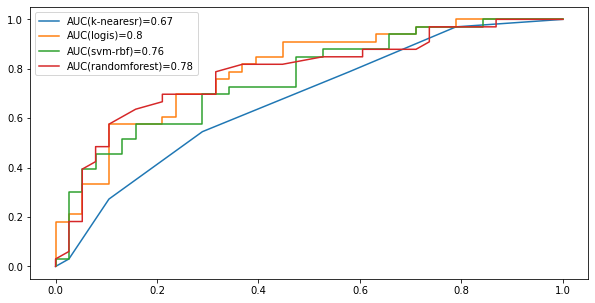

In [59]:
analyzeModels = {
    name:model for name, model in models.items()
}

plt.figure(figsize=(10,5))
aucs = []
for name, model in analyzeModels.items():
    y_scores_n = model.predict_proba(X_test_n)
    
    alive_scores = y_scores_n[:,1]
    
    # Extract AUC score
    auc = roc_auc_score(y_test_n, alive_scores)
    aucs.append(f"AUC({name})={round(auc,2)}")
    # Extract ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_n, alive_scores, pos_label=1)
    plt.plot(fpr,tpr)

plt.legend(aucs)

In [57]:
for name, model in models.items():
    scores = cross_val_score(model, X_normalized, y_normalized, cv=10)
    print(f"({name}) acccuracy={np.mean(scores)}")

(k-nearesr) acccuracy=0.6576984126984127


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scik

(logis) acccuracy=0.7196825396825397
(svm-rbf) acccuracy=0.6059523809523808
(randomforest) acccuracy=0.7167460317460318


In [58]:
# Precision, Recall, F1-Score & Support
#print(classification_report(y_test,y_pred))
# Accuracy Score -> in mutliclass is computed with jaccard_score
#print(accuracy_score(y_test, y_pred))

for name, model in models.items():
    y_pred_n = model.predict(X_test_n)
    print(f"MODEL -> {name}")
    print(classification_report(y_test_n,y_pred_n))

MODEL -> k-nearesr
              precision    recall  f1-score   support

           0       0.64      0.71      0.67        38
           1       0.62      0.55      0.58        33

    accuracy                           0.63        71
   macro avg       0.63      0.63      0.63        71
weighted avg       0.63      0.63      0.63        71

MODEL -> logis
              precision    recall  f1-score   support

           0       0.74      0.76      0.75        38
           1       0.72      0.70      0.71        33

    accuracy                           0.73        71
   macro avg       0.73      0.73      0.73        71
weighted avg       0.73      0.73      0.73        71

MODEL -> svm-rbf
              precision    recall  f1-score   support

           0       0.80      0.53      0.63        38
           1       0.61      0.85      0.71        33

    accuracy                           0.68        71
   macro avg       0.70      0.69      0.67        71
weighted avg       0.71